In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
from laughter_prediction.feature_extractors import MFCCFeatureExtractor
from laughter_prediction.predictors import RnnPredictor

In [11]:
class VocalizationSet(Dataset):
    def __init__(self, data_path, steps_per_second):
        super(VocalizationSet, self).__init__()
        self.steps_per_second = steps_per_second
        self.step_len = steps_per_second ** -1
        self.sampler = SSPNetDataSampler(data_path)
        self.paths = self.sampler.get_valid_wav_paths()
        self.extractor = MFCCFeatureExtractor(steps_per_second)

    def __getitem__(self, item):
        fbank, mfcc = self.extractor.extract_features(self.paths[item])
        labels = self.sampler.get_labels_for_file(self.paths[item], self.step_len)
        is_laughter = labels['IS_LAUGHTER'].values.astype(np.long)
        fbank = torch.tensor(fbank.T.astype(np.float32))
        mfcc = torch.tensor(mfcc.T.astype(np.float32))
        labels = torch.tensor(is_laughter, dtype=torch.long)
        n = min(len(fbank), len(labels))
        return fbank[:n], mfcc[:n], labels[:n]

    def __len__(self):
        return len(self.paths)

In [3]:
def probs_to_mask(probs):
    probs = np.array(probs)
    return probs[:, 1] > probs[:, 0]

def acc(prediction, target):
    target = target.numpy()
    prediction = probs_to_mask(prediction)
    return np.mean(target == prediction)

def evaluate(model, data, mfcc_loss_function, both_loss_function):
    mfcc_losses = []
    both_losses = []
    mfcc_accuracies = []
    both_accuracies = []
    for features_fb, features_mfcc, labels in data:
        mfcc_prediction, both_prediction = model.predict_proba((features_fb, features_mfcc))
        labels = labels.squeeze()
        mfcc_loss = mfcc_loss_function(mfcc_prediction, labels)
        both_loss = both_loss_function(both_prediction, labels)
        mfcc_losses.append(mfcc_loss.detach().numpy())
        both_losses.append(both_loss.detach().numpy())
        mfcc_accuracies.append(acc(mfcc_prediction.detach(), labels))
        both_accuracies.append(acc(both_prediction.detach(), labels))
    return np.mean(mfcc_losses), np.mean(both_losses), np.mean(mfcc_accuracies), np.mean(both_accuracies)

def train(model, train_data, test_data, epochs, mfcc_loss_function, both_loss_function):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    for i in range(epochs):
        mfcc_losses = []
        both_losses = []
        for features_fb, features_mfcc, labels in train_data:
            model.zero_grad()

            mfcc_prediction, both_prediction = model.predict_proba((features_fb, features_mfcc))
            
            labels = labels.squeeze()
            mfcc_loss = mfcc_loss_function(mfcc_prediction, labels)
            both_loss = both_loss_function(both_prediction, labels)
            loss = mfcc_loss + both_loss
            
            loss.backward()
            optimizer.step()
            
            mfcc_losses.append(mfcc_loss.detach().numpy())
            both_losses.append(both_loss.detach().numpy())
        print(f'Epoch {i + 1}. Train MFCC losss: {np.mean(mfcc_losses)}, common loss: {np.mean(both_losses)}')
        test_mfcc_loss, test_both_loss, test_mfcc_acc, test_both_acc = \
                evaluate(model, test_data, mfcc_loss_function, both_loss_function)
        print(f'Evaluation loss: {test_mfcc_loss} MFCC, {test_both_loss} both. Accuracy: {test_mfcc_acc} MFCC, {test_both_acc} both')

In [18]:
import os
import json


def get_split(n, path):
    if os.path.isfile(path):
        with open(path, 'rt') as file:
            split = json.load(file)
        return np.array(split['train']), np.array(split['test'])
    else:
        test_len = int(TEST_SHARE * n)
        test_indices = np.random.choice(n, test_len, replace=False)
        train_mask = np.ones(n, dtype=np.bool)
        train_mask[test_indices] = False
        train_indices = np.argwhere(train_mask).flatten()
        with open(path, 'wt') as file:
            json.dump({
                'train': [int(i) for i in train_indices],
                'test': [int(i) for i in test_indices]
            }, file)
        return train_indices, test_indices
    

TEST_SHARE = .2


def load_data(paths, indices_proc):
    dataset = ConcatDataset([VocalizationSet(path, 50) for path in paths])
    train_indices, test_indices = get_split(len(dataset), 'tts.json')
    # This is done for restoring test/train separations for clear and noisy data
    train_indices, test_indices = indices_proc(train_indices), indices_proc(test_indices)
    train_loader = DataLoader(dataset, num_workers=3, sampler=SubsetRandomSampler(train_indices))
    test_loader = DataLoader(dataset, num_workers=3, sampler=SubsetRandomSampler(test_indices))
    return train_loader, test_loader

In [5]:
train_data_loader, test_data_loader = load_data(['vocalizationcorpus', 'vocalizationcorpus_noisy'], lambda x: x)

In [6]:
rnn = RnnPredictor()

In [7]:
from time import time

In [8]:
mfcc_loss_f = torch.nn.CrossEntropyLoss()
both_loss_f = torch.nn.CrossEntropyLoss()
t = time()
train(rnn, train_data_loader, test_data_loader, 20, mfcc_loss_f, both_loss_f)
print(time() - t)
torch.save(rnn.state_dict(), 'rnn.pth')

Epoch 1. Train MFCC losss: 0.6957051753997803, common loss: 0.4330597519874573
Evaluation loss: 0.693147599697113 MFCC, 0.36008238792419434 both. Accuracy: 0.9613544955958119 MFCC, 0.9614724945986372 both
Epoch 2. Train MFCC losss: 0.693146824836731, common loss: 0.3505249321460724
Evaluation loss: 0.6931459307670593 MFCC, 0.3522374629974365 both. Accuracy: 0.9614625228519195 MFCC, 0.9614724945986372 both
Epoch 3. Train MFCC losss: 0.52338707447052, common loss: 0.34782737493515015
Evaluation loss: 0.38173624873161316 MFCC, 0.351133793592453 both. Accuracy: 0.9614724945986374 MFCC, 0.9617915904936015 both
Epoch 4. Train MFCC losss: 0.36156031489372253, common loss: 0.34729355573654175
Evaluation loss: 0.35665130615234375 MFCC, 0.35058557987213135 both. Accuracy: 0.9614724945986374 MFCC, 0.9622901778294829 both
Epoch 5. Train MFCC losss: 0.35018229484558105, common loss: 0.3470960557460785
Evaluation loss: 0.35266628861427307 MFCC, 0.35028403997421265 both. Accuracy: 0.9614724945986372 

In [19]:
train_voc, test_voc = load_data(['vocalizationcorpus'], lambda inds: inds[inds < 2735])
evaluate(rnn, test_voc, mfcc_loss_f, both_loss_f)

(0.34955436, 0.34817585, 0.9622488038277511, 0.9647505126452495)

In [20]:
train_noisy, test_noisy = load_data(['vocalizationcorpus_noisy'], lambda inds: inds[inds > 2735] - 2735)
evaluate(rnn, test_noisy, mfcc_loss_f, both_loss_f)

(0.3502003, 0.34885618, 0.96073762536396, 0.964060174700744)

In [58]:
import matplotlib.pyplot as plt
from laughter_classification.visualization import plot_ROC_curve

def plot_prediction(labels, mfcc_pred, both_pred):
    plt.plot(labels, label='Groudtruth')
    plt.plot(both_pred, label='All features')
    plt.plot(mfcc_pred, label='MFCC features')
    plt.legend()
    plt.show()

def predict(model, dataset, index):
    features_fb, features_mfcc, labels = dataset[index]
    pred = model.predict_proba((features_fb.unsqueeze(0), features_mfcc.unsqueeze(0)))
    return pred[0][:, 1].detach().numpy(), pred[1][:, 1].detach().numpy(), labels.numpy()

In [28]:
all_clear = VocalizationSet('vocalizationcorpus', 50)

Track 232


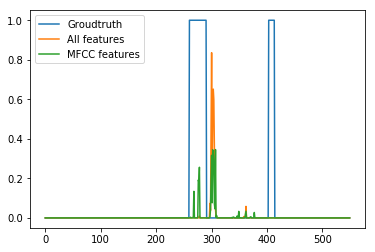

ROC on MFCC features


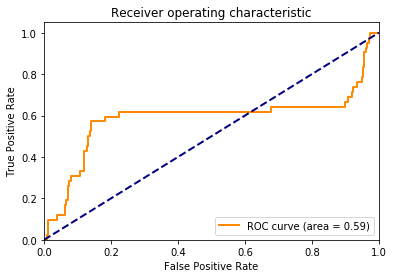

ROC on all features


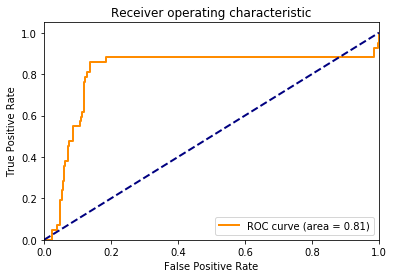

Track 2474


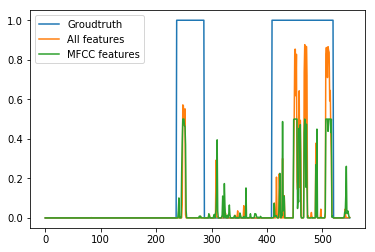

ROC on MFCC features


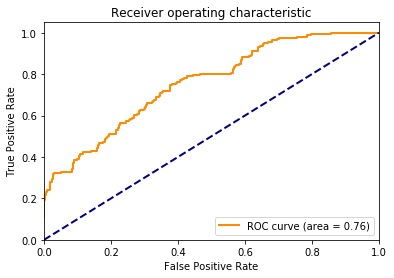

ROC on all features


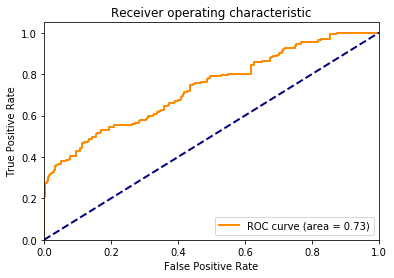

Track 526


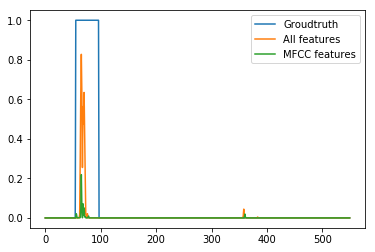

ROC on MFCC features


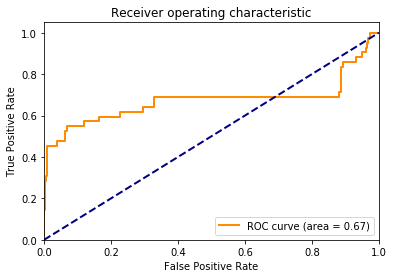

ROC on all features


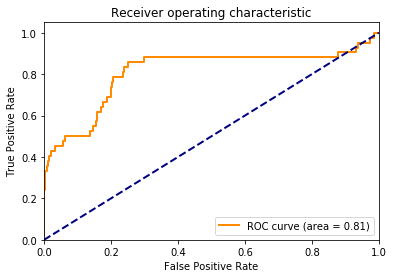

Track 165


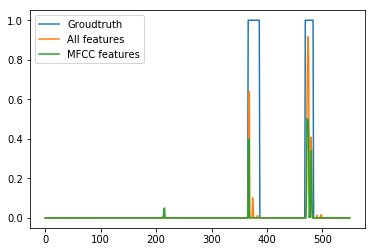

ROC on MFCC features


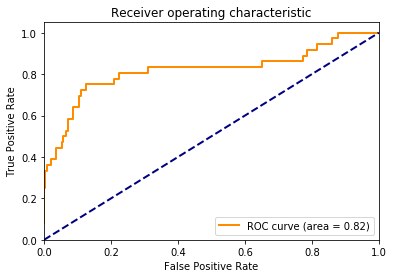

ROC on all features


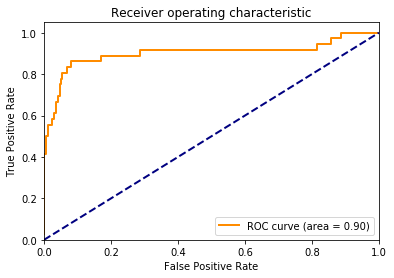

Track 655


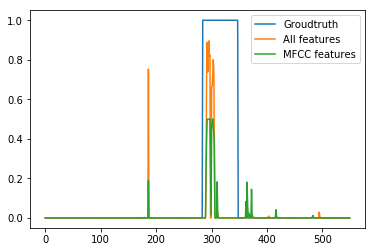

ROC on MFCC features


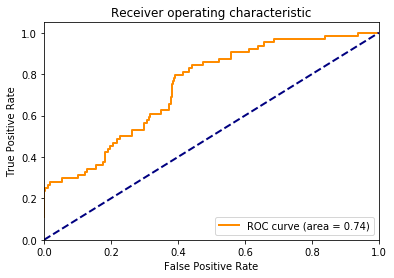

ROC on all features


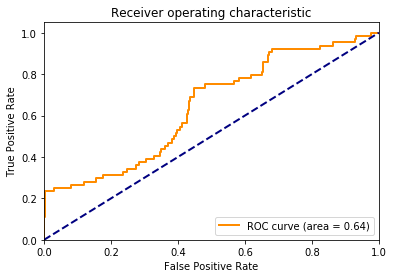

In [63]:
for _ in range(5):
    i = np.random.randint(len(all_clear))
    pred_mfcc, pred_both, labels = predict(rnn, all_clear, i)
    while not np.any(labels):
        i = np.random.randint(len(all_clear))
        pred_mfcc, pred_both, labels = predict(rnn, all_clear, i)
    print(f'Track {i}')
    plot_prediction(labels, pred_mfcc, pred_both)
    print('ROC on MFCC features')
    plot_ROC_curve(pred_mfcc, labels)
    print(f'ROC on all features')
    plot_ROC_curve(pred_both, labels)